<img src="./Data/logo-ensae.jpg" width = 60%>

<img src="./Data/logo-ipparis.jpg" width = 50%>

**"Projet Informatique", S2 2018-19** 
# *Wireless Data Traffic Change Point Detection*  

**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

## Abstract
- Python -> Python Elasticsearch Client -> Elasticsearch -> Kibana

In [158]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Introduction

Bandwidth is one of the KPIs in the telecommunication and Internet industry. There have been a lot of research made in this field, from anomaly detection to prediction.

Although many bandwidth predictions are made by telecom companies using their confidential or difficult-to-obtain data such as geolocation of base stations, number of users connected, and data flow in the backbone network, there have been relatively less work carried out in the micro point of view -- distance of user's phone to the access point, shape of the room users are in, and any other characteristics specific to the particular environment in which user's devices are connected.

This project attempts to study environmental characteristics with a focus on distance between devices and access point using a turning point detection method.

## 2. Environment

- Python $\rightarrow$ Python Elasticsearch Client $\rightarrow$ Elasticsearch $\rightarrow$ Kibana $\rightarrow$ Jupyter notebook
- After connecting both the laptop and the Raspberry Pi to the phone by tethering, we continue sending a ping (echo) request to the Raspberry Pi every second, and measure the time that takes until we receive a ping (echo) reply back from the Raspberry Pi.

<img src="./Data/env.png" width = 60% align="left">

## 3. Method

- We employ **changefinder** library to detect change points.

- Changefinder uses SDAR（Sequentially Discounting Auto Regressive）algorithm to detect change points.

- Changeinder calculates outlier score, whose higher score indicates that there was a change in the data stream.

## 4. Empirical Result

- Import necessary libraries.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from elasticsearch import Elasticsearch
import subprocess
import time
import datetime
import re
import IPython
import statsmodels.api as sm
import changefinder

### 4.1. Ping to Raspberry Pi

- 172.20.10.6 is the IP address of the raspberry pi.

In [169]:
es = Elasticsearch()
t = 0
destination = "172.20.10.6"
df = pd.DataFrame({'Timestamp': [datetime.datetime.utcnow()],
                   'ms': [0],})

print('Ping to %s started..' %destination)

while True:
    time.sleep(1)
    t += 1

    timestamp = datetime.datetime.utcnow()
    print('\r', timestamp, ' : ', end="")
    try:
        pg_res = subprocess.check_output(["ping", "-c", "1", "-S", "0.0.0.0", destination])
        
    except subprocess.CalledProcessError:
        print('\nping unreachable (CalledProcessError, t=%d)' %t)
        continue
    
    ms_res = float(re.search(r"time=([0-9]+).([0-9]+)" , pg_res.decode('utf-8')).group(0)[5:])
    print('%d ms (t=%d)' %(ms_res, t), end="")
    
    new = pd.Series([timestamp, ms_res], index=df.columns)
    df = df.append(new, ignore_index=True)
    
    # Create a json document to be posted to Elasticsearch
    doc = {
        'Timestamp': timestamp,
        'ms': ms_res,
    }
    
    # Create an index (database) that includes the document
    res1 = es.index(index="ping-time-index", doc_type='ping-time', id=t, body=doc)
    
    # Refresh the specified index to guarantee the searchability of the document
    es.indices.refresh(index="ping-time-index")

Ping to 172.20.10.6 started..
 2019-04-28 05:43:55.906112  : 172 ms (t=12)
ping unreachable (CalledProcessError, t=13)
 2019-04-28 05:44:07.922764  : 
ping unreachable (CalledProcessError, t=14)
 2019-04-28 05:44:32.646795  : 54 ms (t=26)
ping unreachable (CalledProcessError, t=27)
 2019-04-28 05:45:29.577544  : 32 ms (t=70))

KeyboardInterrupt: 

In [168]:
df1 = df.drop(index=0)

### 4.2. Data Visualisation

- We use Kibana platform in order to visualise real-time evolution of ping time.
- A sample picture of the real-time graph can be captured using the following command.

In [159]:
%%html
<iframe src="http://localhost:5601/app/kibana#/dashboard/e9183d80-579e-11e9-b63b-f785f201c52a?embed=true&_g=(refreshInterval%3A(pause%3A!t%2Cvalue%3A0)%2Ctime%3A(from%3Anow-5m%2Cmode%3Arelative%2Cto%3Anow))" height="600" width="800"></iframe>

- Kill the above ping process, then the entire detailed data can be displayed as following.

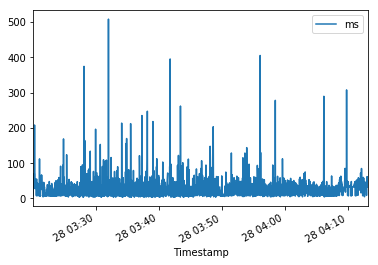

In [121]:
df1.plot.line(x='Timestamp', y='ms')

### 4.3. Time series pre-analysis
- We run a preliminary analysis of the obtained time series data.
- We can observe that our traffic speed data is not auto-correlated.

In [ ]:
df_x
df_y

In [115]:
df_y = df1
raw_data = df_y.ms

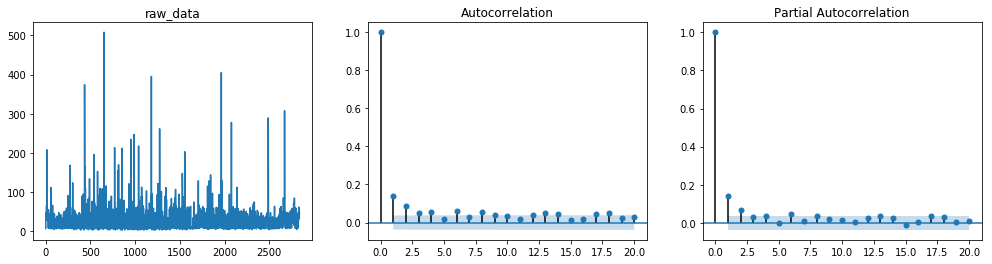

In [156]:
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
axes = ax.flatten()
diff_color = "#800000"

axes[0].plot(raw_data)
axes[0].set_title("raw_data")
fig = sm.graphics.tsa.plot_acf(raw_data, lags=20, ax=axes[1])
fig = sm.graphics.tsa.plot_pacf(raw_data, lags=20, ax=axes[2])

In [122]:
data = df1['ms'].as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### 4.4. Change Point Detection
- Blue: Data, Red: Change point score

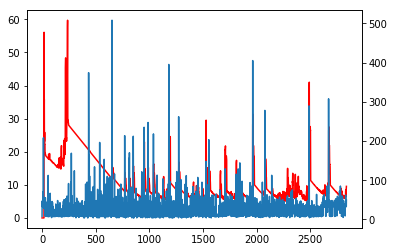

In [157]:
"""data=np.concatenate([np.random.normal(0.7, 0.05, 300),
np.random.normal(1.5, 0.05, 300),
np.random.normal(0.6, 0.05, 300),
np.random.normal(1.3, 0.05, 300)])
"""
 
cf = changefinder.ChangeFinder(r=0.02, order=5, smooth=7)
 
ret = []
for i in data:
    score = cf.update(i)
    ret.append(score)
 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ret, 'r')
ax2 = ax.twinx()
ax2.plot(data)
plt.show()

## 5. Conclusion

- We have identified change points correctly with a minor number of errors.
- For further development, change point can be detected online then alert it via Kibana (and email). To do this, calculating the outlier score with regular interval (e.g. 10 seconds) could be an option.
- There is also a possibility to fine tune the hyperparameters of the model based on the user's environment. Further empirical research with different kinds of environment could be a help.